# Training Loop

Use fastai to implement the training loop for training a Soft Decision Tree

In [ ]:
# default_exp train

In [ ]:
#hide
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
  !pip3 install -Uqq fastbook

     |████████████████████████████████| 727kB 21.9MB/s 
     |████████████████████████████████| 1.1MB 52.4MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 194kB 56.9MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 


In [ ]:
#hide
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
if IN_COLAB:
  from pathlib import Path
  from nbdev.imports import Config
  project_path = Path('/content/drive/My Drive/Colab Notebooks/github/sdt')
  get_ipython().magic(f'cd {project_path}')
  get_ipython().magic(f'cd {Config().nbs_path}')

/content/drive/My Drive/Colab Notebooks/github/sdt
/content/drive/My Drive/Colab Notebooks/github/sdt


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai.vision.all import *

from sdt.data  import *
from sdt.model import *
from sdt.loss  import *

## Train

In [ ]:
#export
class SDTCallback(Callback):
  run_before=Recorder

  def __init__(self, tree, n_leaves, prob=1.):
    self.tree     = tree
    self.n_leaves = n_leaves
    self.prob     = prob
  
  def after_pred(self):
    self.learn.path_prob, self.learn.pred = self.pred
    self.learn.loss_func.set_path_prob(self.path_prob)
    self.learn.loss_func.set_regularizer(self.learn.model.get_numers,
                                    self.learn.model.get_denoms
                                    )
    self.learn.model.reset()

  def after_loss(self):
    path_prob, outs = self.path_prob, self.pred
    target_indices  = path_prob.argmax(dim=1)
    max_path_prob   = outs[torch.arange(outs.shape[0]), target_indices]
    pred_target     = max_path_prob.argmax(dim=1)

    self.learn.pred = pred_target

In [ ]:
#ignore
path = untar_data(URLs.MNIST)
dls  = get_dls(path, bs=128)

In [ ]:
#ignore
current_depth = 0
depth = 4

tree      = Tree(input_dim=784, output_dim=10)
n_leaves  = 2 ** depth
n_classes = 10
n_epochs  = 40

tree = sdt_init(current_depth , depth, tree, input_dim=784, output_dim=n_classes)

# SDT
sdt       = SDT(tree=tree, n_leaves=n_leaves, n_classes=n_classes)
criterion = SDTLoss(lambda_=0.05)

In [ ]:
#ignore
learn = Learner(dls, 
                sdt, 
                loss_func=criterion, 
                opt_func=partial(SGD, lr=.2, mom=0.9), 
                cbs=SDTCallback(tree, n_leaves), 
                metrics=partial(accuracy_multi, sigmoid=False))

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=1.9054607152938843)

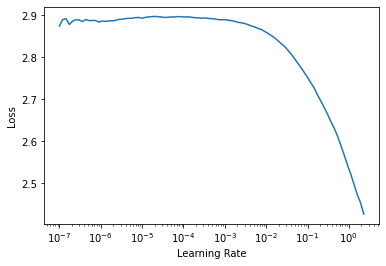

In [ ]:
#ignore
learn.lr_find()

In [ ]:
#ignore
learn.fit_one_cycle(n_epoch=n_epochs)

epoch,train_loss,valid_loss,accuracy_multi,time
0,2.744646,2.727949,0.412857,01:02
1,2.586069,2.566797,0.486786,01:00
2,2.419720,2.406863,0.563571,01:00
3,2.262096,2.251291,0.647500,00:59
4,2.115933,2.106572,0.900929,00:59
5,1.984815,1.982390,0.900929,01:00
6,1.875329,1.865374,0.900929,01:00
7,1.765059,1.767295,0.900929,01:00
8,1.680787,1.678935,0.900929,01:00
9,1.594556,1.595922,0.964714,01:01


In [ ]:
#ignore
learn.export()

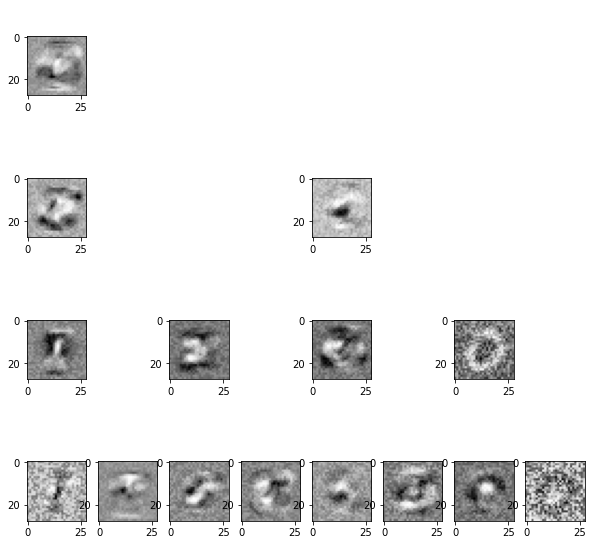

In [ ]:
#ignore
fig, ax = plt.subplots(4, 8, figsize=(10, 10))

for name, p in learn.model.named_parameters():
  if name == 'tree.fc.weight':
    ax[0][0].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.fc.weight':
    ax[1][0].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.fc.weight':
    ax[1][4].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.left.fc.weight':
    ax[2][0].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.right.fc.weight':
    ax[2][2].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.left.fc.weight':
    ax[2][4].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.right.fc.weight':
    ax[2][6].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.left.left.fc.weight':
    ax[3][0].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.left.right.fc.weight':
    ax[3][1].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.right.left.fc.weight':
    ax[3][2].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.left.right.right.fc.weight':
    ax[3][3].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.left.left.fc.weight':
    ax[3][4].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.left.right.fc.weight':
    ax[3][5].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.right.left.fc.weight':
    ax[3][6].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')
  if name == 'tree.right.right.right.fc.weight':
    ax[3][7].imshow(p.view(28, 28).cpu().detach().numpy(), cmap='Greys')


for i in range(0, 8):
  if i > 0: ax[0][i].set_axis_off()
  
for i in range(0, 8):
  if i not in [0, 4]: ax[1][i].set_axis_off()

for i in range(0, 8):
  if i not in [0, 2, 4, 6]: ax[2][i].set_axis_off()

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_model.ipynb.
Converted 02_loss.ipynb.
Converted 03_train.ipynb.
Converted index.ipynb.


In [ ]:
#ignore
from nbdev.cli import nbdev_build_docs
nbdev_build_docs()

converting: /content/drive/My Drive/Colab Notebooks/github/sdt/index.ipynb
converting: /content/drive/My Drive/Colab Notebooks/github/sdt/02_loss.ipynb
converting: /content/drive/My Drive/Colab Notebooks/github/sdt/01_model.ipynb
converting: /content/drive/My Drive/Colab Notebooks/github/sdt/00_data.ipynb
converting: /content/drive/My Drive/Colab Notebooks/github/sdt/03_train.ipynb
converting /content/drive/My Drive/Colab Notebooks/github/sdt/index.ipynb to README.md


In [ ]:
#ignore
from nbdev.cli import nbdev_test_nbs
nbdev_test_nbs()

testing /content/drive/My Drive/Colab Notebooks/github/sdt/00_data.ipynb
testing /content/drive/My Drive/Colab Notebooks/github/sdt/01_model.ipynb
testing /content/drive/My Drive/Colab Notebooks/github/sdt/02_loss.ipynb
testing /content/drive/My Drive/Colab Notebooks/github/sdt/03_train.ipynb


In [ ]:
#ignore
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   README.md
	modified:   docs/_data/sidebars/home_sidebar.yml
	modified:   docs/data.html
	modified:   docs/index.html
	modified:   docs/loss.html
	modified:   docs/model.html
	modified:   docs/sidebar.json
	modified:   docs/train.html
	modified:   index.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	docs/images/learned_filters.png
	docs/images/loss.png
	docs/images/regularizer.png
	docs/images/training_loop.png
	export.pkl

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
#ignore
!git add README.md docs/ index.ipynb; git config --global user.email 'abhicoders@gmail.com'; git config --global user.name 'numb3r33'; git commit -m 'push docs'

[main e4b5c90] push docs
 13 files changed, 298 insertions(+), 331 deletions(-)
 rewrite README.md (82%)
 create mode 100644 docs/images/learned_filters.png
 create mode 100644 docs/images/loss.png
 create mode 100644 docs/images/regularizer.png
 create mode 100644 docs/images/training_loop.png
 rewrite index.ipynb (100%)


In [ ]:
#ignore
from nbdev.cli import nbdev_clean_nbs
nbdev_clean_nbs()

In [ ]:
#ignore
from nbdev.cli import nbdev_install_git_hooks
nbdev_install_git_hooks()

Executing: git config --local include.path ../.gitconfig
Success: hooks are installed and repo's .gitconfig is now trusted


In [ ]:
#ignore
!git push origin main

Counting objects: 15, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (14/14), done.
Writing objects: 100% (15/15), 5.27 KiB | 675.00 KiB/s, done.
Total 15 (delta 12), reused 0 (delta 0)
remote: Resolving deltas: 100% (12/12), completed with 11 local objects.
To https://github.com/numb3r33/sdt
   57d78d1..e4b5c90  main -> main
